# Springboard--DSC Program

# Capstone Project 1 - Milestone Report 
### by Ellen A. Savoye

# Introduction

Openly discussing things that you feel strongly about, or care about can be difficult; even more so online or in discussion boards where the threat of abuse and harassment can be prominent. Many messaging and discussion-based platforms struggle to filter out toxic and outwardly offensive comments including comments that are rude, disrespectful or otherwise likely to make someone feel vulnerable and leave a discussion. To combat this, ultimately, most platforms limit or completely remove offensive comment sections as a result. With the advancement of computing technology, including AI, assessment and learning, can a code be developed to recognize toxic comments in online conversations with respect to mentions of identities?

Conversation AI, a joint venture between Jigsaw and Google (both subsidiaries of Alphabet), have been the primary business prompting this problem. Even though this is one of the focuses of the Conversation AI team, the question of recognizing these potentially hazardous comments has a far-reaching impact on more online platforms and businesses than just this joint-venture.

# Data

The data used for this project is publicly available at the following address: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data. These data are originally from Civil Comments, a collection of about 2 million public comments. I sourced the 'train.csv' data used in my capstone report from the aforementioned link. 

The original 'train' dataset consists of 45 columns: 24 identity labels, 1 target variable containing values from 0 to 1, 1 comment_text variable, 6 target label subsets, and  13 metadata variables.

Given the size of the original dataset, approximately 1.8 million records, I took a 10% sample to test various NLP cleaning techniques. The purpose was two-fold. One, test code to ensure it functions as it should. Two, quantify the impact of the code to determine if using a particular cleaning technique was necessary or impactful.

I eventually created a function, called normalize_corpus, to apply to all ~1.8 million records. The function removed emoji, emoticon, punctuation, stopwords, and special characters. It also converted my text field entirely to lower case values. I did not remove digits nor did I lemmatize the text. Without running the cleaned text with what I had done so far, I was hesitant to continue wrangling without a baseline model to test against. 

# Exploratory Analysis

In [2]:
import pandas as pd
import numpy as np

# # libraries for NLP
# import spacy
# import nltk
# from nltk.tokenize.toktok import ToktokTokenizer
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords

# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
# from scipy import stats
# from scipy.stats import pearsonr

# libraries for getting and moving data
import os
from os import path
import shutil
from zipfile import ZipFile

# for Images
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Set directories
# Google Colab
src = "/content/drive/My Drive/DS-Capstone_1/Code/"
dst = "/content/drive/My Drive/DS-Capstone_1/Data/"

# Colab path
unpickled_df = pd.read_pickle(dst + 'full_data_w_features.pkl')
unpickled_df_slimmed = pd.read_pickle(dst + 'slimmed_data_w_features.pkl')


During EDA, I wanted to determine if my dataset was balanced between toxic and non-toxic comments. My gut instinct was that it wasn't balanced but I didn't realize how unbalanced it ended up being. In the graph below, you can see that 92% of the data is non-toxic. This solidified my belief that I needed to use a confusion matrix, precision, and recall to aid in determining model success. 

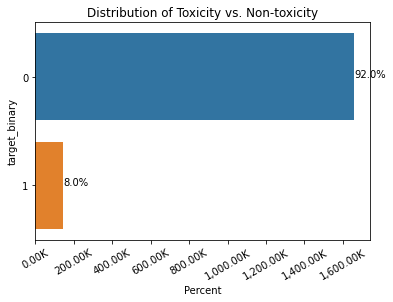

In [3]:
# Full data set
ax = sns.countplot(y="target_binary", data=unpickled_df)
plt.title('Distribution of Toxicity vs. Non-toxicity')
plt.xlabel('Percent')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

total = len(unpickled_df['target_binary'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

Post dataset balancing, I was curious if the stopwords had as much impact as they did. Using uni-, bi-, and tri-grams, I determined the top 20 words for each. Unfortunately, stopwords were prevelant in all 3. As a result, I created word clouds without stopwords over 3 buckets using the target variable: high, neutral, and low toxicity. 

In [6]:
unpickled_df_low = unpickled_df[unpickled_df.Toxicity_Bins == 'Low'].clean_text
unpickled_df_neutral = unpickled_df[unpickled_df.Toxicity_Bins == 'Neutral'].clean_text
unpickled_df_high = unpickled_df[unpickled_df.Toxicity_Bins == 'High'].clean_text

# All 'high' reviews:
text_high = " ".join(comment for comment in unpickled_df_high)
print ("There are {} words in the combination of all 'high toxicity' comments.".format(len(text_high)))

# All 'neutral' reviews:
text_neutral = " ".join(comment for comment in unpickled_df_neutral)
print ("There are {} words in the combination of all 'neutral toxicity' comments.".format(len(text_neutral)))

# All 'low' reviews:
text_low = " ".join(comment for comment in unpickled_df_low)
print ("There are {} words in the combination of all 'low toxicity' comments.".format(len(text_low)))

There are 14405533 words in the combination of all 'high toxicity' comments.
There are 43155436 words in the combination of all 'neutral toxicity' comments.
There are 459023008 words in the combination of all 'low toxicity' comments.


In [0]:
# set up for word clouds
def plot_wordcloud(wordcloud):
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

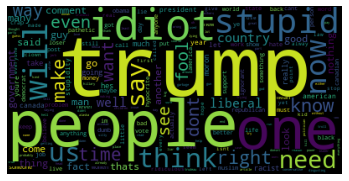

In [6]:
# Create and generate a word cloud image for each bin:
wordcloud_high = WordCloud().generate(text_high)
plot_wordcloud(wordcloud_high)

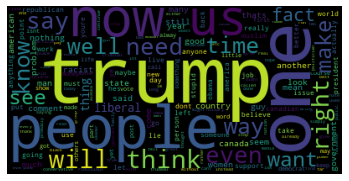

In [7]:
# Create and generate a word cloud image for each bin:
wordcloud_neutral = WordCloud().generate(text_neutral)
plot_wordcloud(wordcloud_neutral)

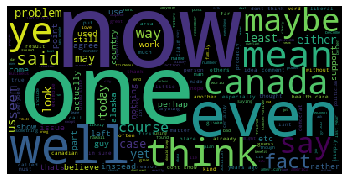

In [0]:
# Create and generate a word cloud image for each bin:
wordcloud_low = WordCloud().generate(text_low)
plot_wordcloud(wordcloud_low)

Between 'high' and 'neutral', trump, one, think, and people stand out the most. In comparison to 'low', only think and one cross all 3 word clouds. The words that stand out in 'low', canada, even, now, and maybe, tend to have a neutral connotation. Comparatively, stupid, idiot, and trump from 'high' have more of a negative connotation, especially in the fraught political environment of society today. By breaking the text into bins and creating word clouds, we are given a snapshot to how negative, neutral, and possibly positive words align with the target value assigned.

In addition to seeing the distribution of words across toxicity buckets, I was curious as to the length of comments and whether or not toxic comments are the same as non-toxic. In splitting the target variable to toxic and non-toxic, I tested my null hypothesis that the average length of toxic comments and average length of non-toxic comments are the same.

My alternative hypothesis was that there is a variation between the averages of toxic and non-toxic comments.

I used a 5% significance level (𝛼=0.05) and a bootstrapped hypothesis to calculate the p-value of the observed difference between toxic and non-toxic comment lengths. 

The p-value calculated was 0.0. Strictly speaking, this is statistically significant. However, one thing to keep in mind is the larger the data set, the easier it is to get a low p-value. In terms of practical significance and practical considerations, yes it is important. Knowing that the average length of comments is different between toxic and non-toxic comments has practical significance in that it lends a certain context. I was originally under the impression that toxic comments were going to be long-winded and longer in length. Between EDA and testing my null hypothesis, I was shown to be incorrect.  

So in the end, I rejected my null hypothesis. 

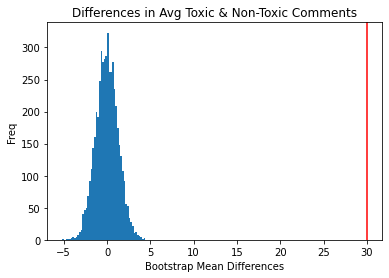

In [0]:
_ = plt.hist(bs_replicates, bins=50)
_ = plt.axvline(x=diff_of_means, color='r')
_ = plt.xlabel('Bootstrap Mean Differences')
_ = plt.ylabel('Freq')
_ = plt.title('Differences in Avg Toxic & Non-Toxic Comments')

In [0]:
def pearsonr_pval(x,y):
    return stats.pearsonr(x,y)[1]

In [0]:
subset_col = ['male', 'female', 'transgender', 'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation',
  'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity',
  'physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability', 'target_binary'] 

In [0]:
identity_subset_df = unpickled_df_slimmed[subset_col].copy()

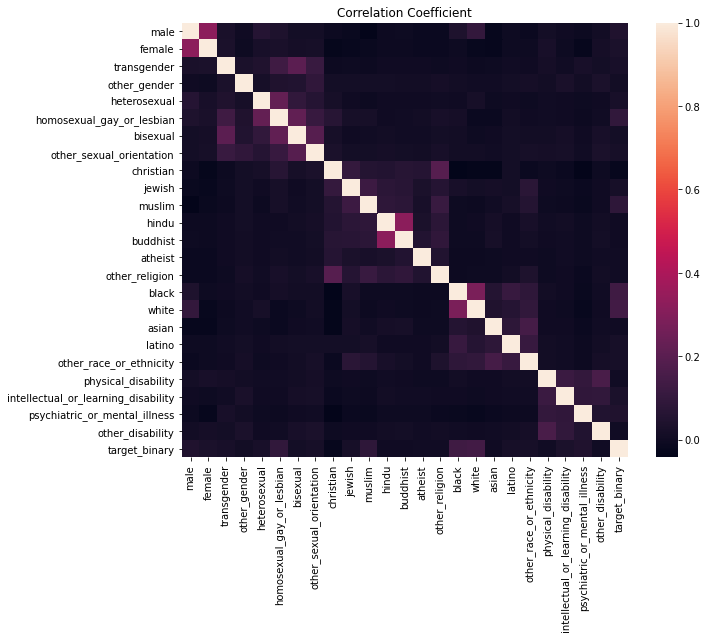

In [0]:
# correlation coefficients
plt.figure(figsize=(10,8))
ax = plt.axes()
ax.set_title('Correlation Coefficient')
sns.heatmap(identity_subset_df.corr(),annot=False,  ax = ax)

Lastly, I checked the correlation between each identity labels and the target variable. Using a dark colored heatmap, it is easily discernible that, aside from a few around 0.4 correlation coefficient, there aren't any correlated fields.

# Summary


Throughout the process, the data has been cleaned and processed for future use in a model. Next steps will be to put the cleaned corpus through a naive bayes and logistic regression models. If necessary, additional cleaning and wrangling will be done to fine tune the models. Outlying after that is potentially running through some machine learning with my cleaned corpus.